# Binary classification model- Neural Network


### Example 1 - Predict hotel cancellations 
you'll build a model to predict hotel cancellations with a binary classifier

### Cross-Entropy 

It measures the difference between the predicted class probabilities and the true class labels(one hot)

The true label for a given example can be represented as a one-hot encoded vector, where the index corresponding to the true class is 1, and all other indices are 0.

The predicted probability distribution is obtained by passing the input through the neural network and applying a softmax activation function to the output layer. The softmax function ensures that the predicted probabilities sum up to 1.

The cross-entropy loss is then calculated by taking the negative logarithm of the predicted probability assigned to the true class. Mathematically, the cross-entropy loss for a single example can be expressed as:

L = -log(p_i),

where L is the loss, p_i is the predicted probability for the true class, and i is the index corresponding to the true class.

The overall cross-entropy loss for a batch of examples is computed by taking the average of the individual losses:

L_avg = (1/N) * sum(L), where N is the number of examples in the batch.



__Read Data__


In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

hotel = pd.read_csv('./data/hotel.csv')

X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

In [6]:
hotel.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### 1) Define Model
The model we'll use this time will have both batch normalization and dropout layers. To ease reading we've broken the diagram into blocks, but you can define it layer by layer as usual.

Define a model with an architecture given by this diagram:

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/V04o59Z.png" width="400" alt="Diagram of network architecture: BatchNorm, Dense, BatchNorm, Dropout, Dense, BatchNorm, Dropout, Dense.">
<figcaption style="textalign: center; font-style: italic"><center>Diagram of a binary classifier.</center></figcaption>
</figure>

<AxesSubplot:title={'center':'Accuracy'}>

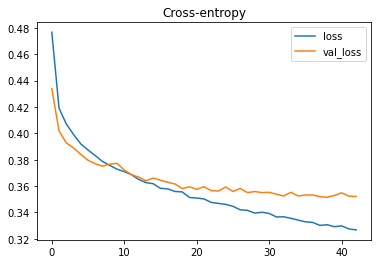

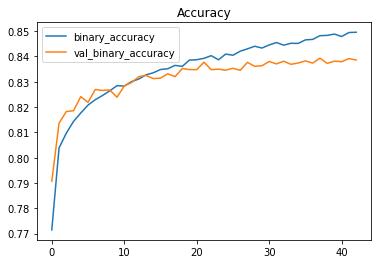

In [35]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu',input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dropout(0.20),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.20),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.20),
    layers.Dense(1,activation='sigmoid')
])

# Add Optimizer, Loss, and Metric
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    verbose =0,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [36]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def plot_metrics(y_test,test_pred, model):
    # Show report clasification test 
    print("Report clasification  TEST --->"+model)
    conf_matrix = confusion_matrix(y_test, test_pred)
    # Create the heatmap diagraman using  seaborn
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
    # setup labels of the axis  x e y
    plt.xlabel('Label Forecast')
    plt.ylabel('Label Real')
    myreport=classification_report(y_test, test_pred)
    print(myreport)
    plt.show()
    return myreport

Though we can see the training loss continuing to fall, the early stopping callback prevented any overfitting. Moreover, the accuracy rose at the same rate as the cross-entropy fell, so it appears that minimizing cross-entropy was a good stand-in. All in all, it looks like this training was a success!

Test set loss -  Accuracy:  0.35249727964401245 0.8380796313285828
933/933 [==============================] - 1s 1ms/step
Report clasification  TEST --->NN
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     18792
           1       0.82      0.72      0.77     11056

    accuracy                           0.84     29848
   macro avg       0.83      0.81      0.82     29848
weighted avg       0.84      0.84      0.84     29848



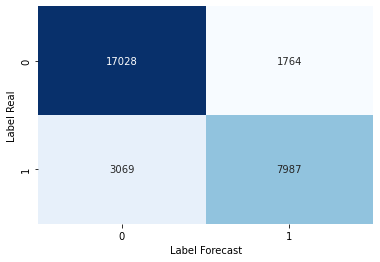

In [37]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=0)
print("Test set loss -  Accuracy: ", loss, accuracy)
# forescating test
nn_test_pred = model.predict(X_valid).flatten()
# Convert the predictions into a binary scale.
#In this case, any value above 0.5 is rounded to 1, and any value below 0.5 is rounded to 0.
nn_test_pred_binary = np.round(nn_test_pred)
nn_base_report = plot_metrics(y_valid, nn_test_pred_binary,"NN")